# Problem Statement

Solar power consumption has been recorded by city councils at regular intervals. The reason behind doing so is to understand how businesses are using solar power so that they can cut down on nonrenewable sources of energy and shift towards renewable energy. Based on the data, build a forecasting model and provide insights on it. 

--- #### ----

Lets load necessary libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (10,12)

In [2]:
data = pd.read_csv('solarpower_cumuldaybyday2.csv')
data.shape

(2558, 2)

2558 rows and 2 columns

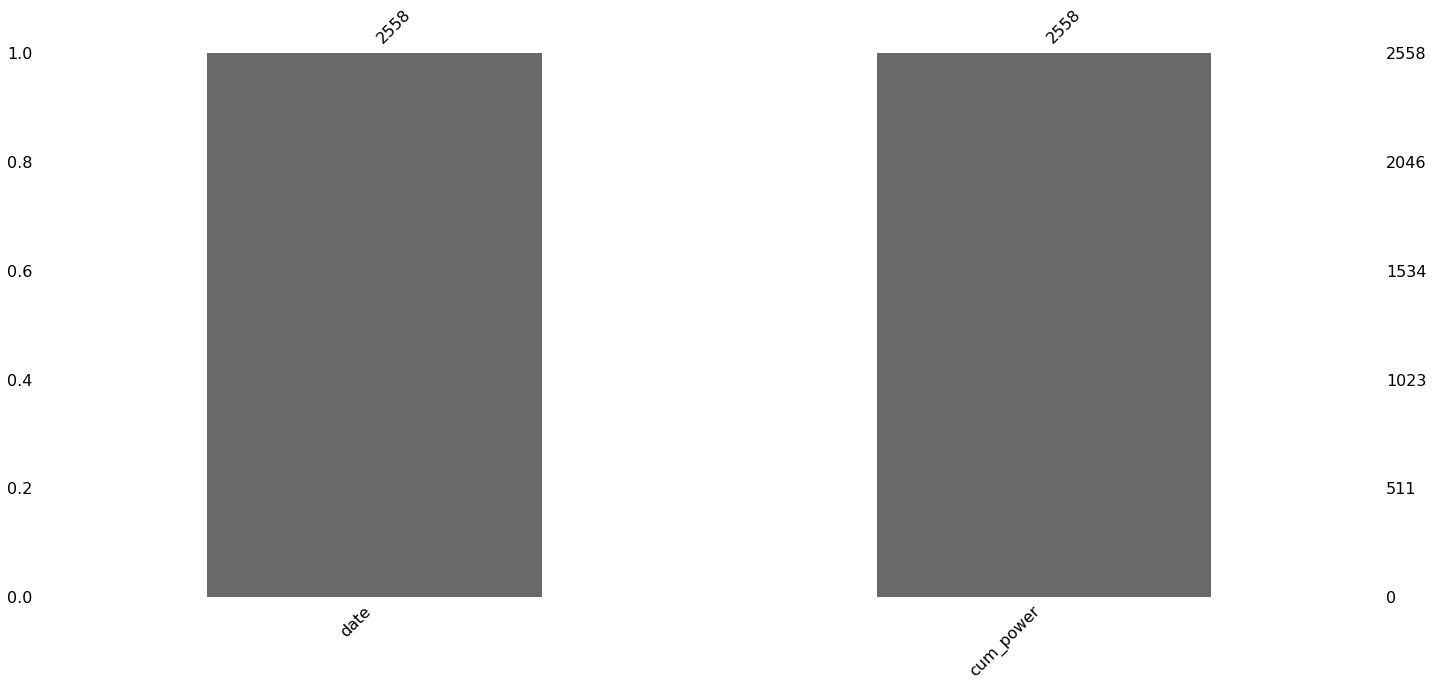

In [3]:
msno.bar(data)

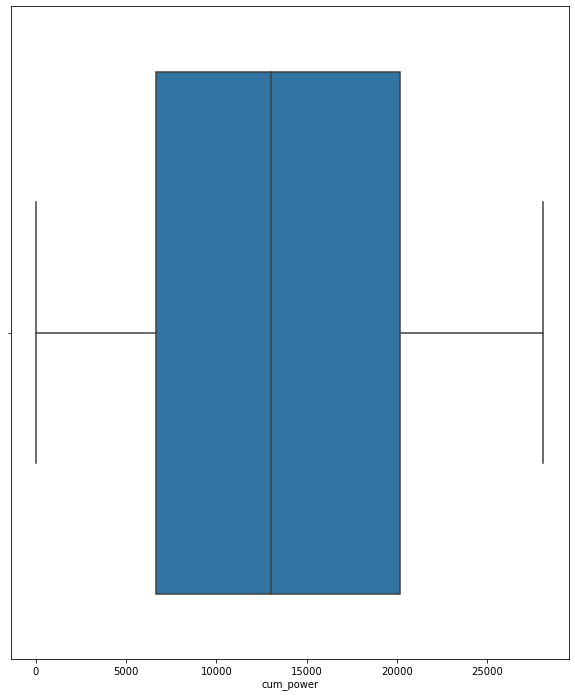

In [4]:
sns.boxplot(data['cum_power'])

In [5]:
data.dtypes

date          object
cum_power    float64
dtype: object

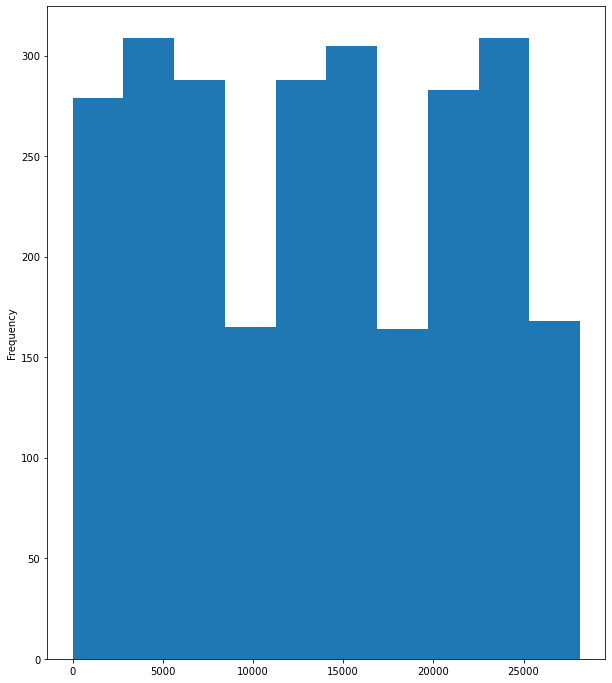

In [6]:
data['cum_power'].plot(kind='hist')

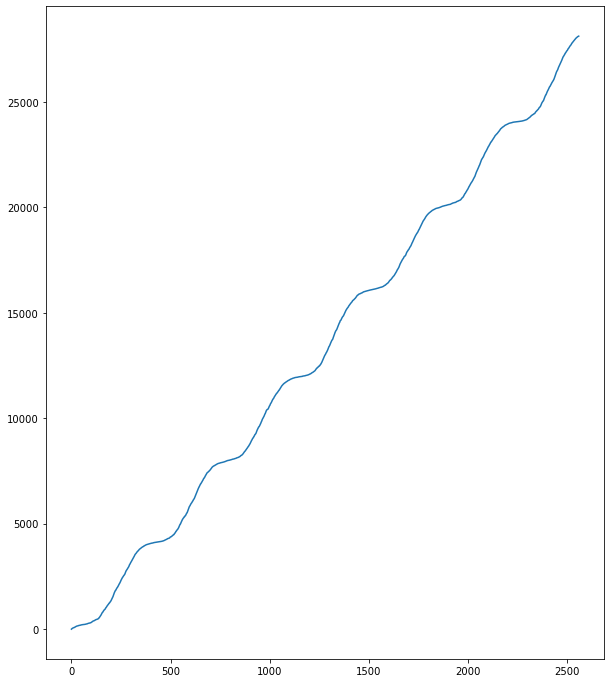

In [7]:
plt.plot(data['cum_power'])

In [8]:
data.head()

,date,cum_power
0,26/10/2011,0.1
1,27/10/2011,10.2
2,28/10/2011,20.2
3,29/10/2011,29.6
4,30/10/2011,34.2


In [9]:
data['date']= pd.to_datetime(data['date'], infer_datetime_format=True)
data.dtypes

date         datetime64[ns]
cum_power           float64
dtype: object

We can see cumilatively there is an upward trend

In [10]:
backup = data.copy()

In [11]:
data.describe()

,cum_power
count,2558.000000
mean,13461.057349
std,8129.192104
min,0.100000
25%,6665.350000
50%,13000.500000
75%,20183.750000
max,28120.000000


In [12]:
data.columns

Index(['date', 'cum_power'], dtype='object')

## Decomposition Chart

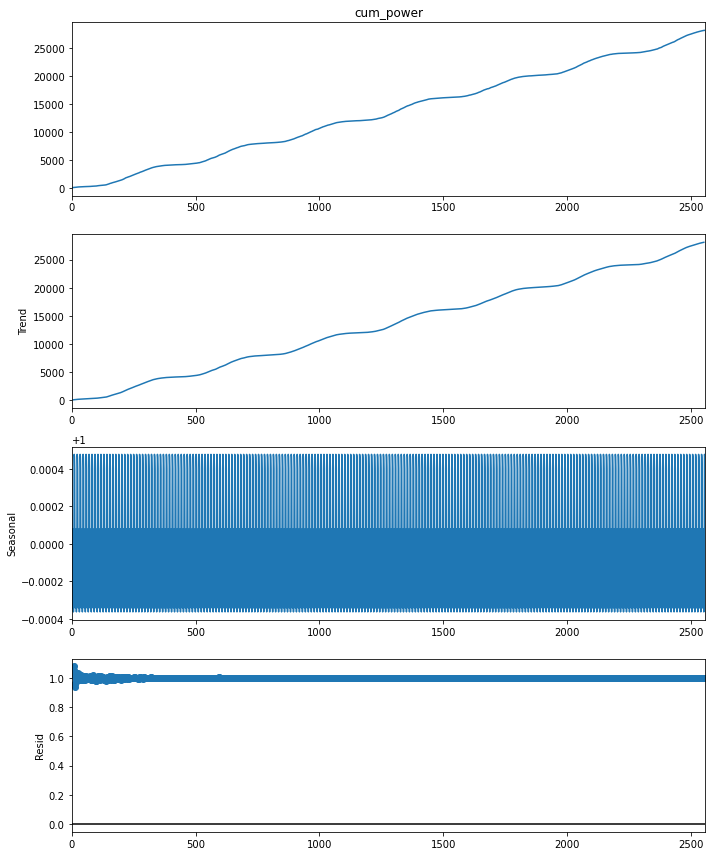

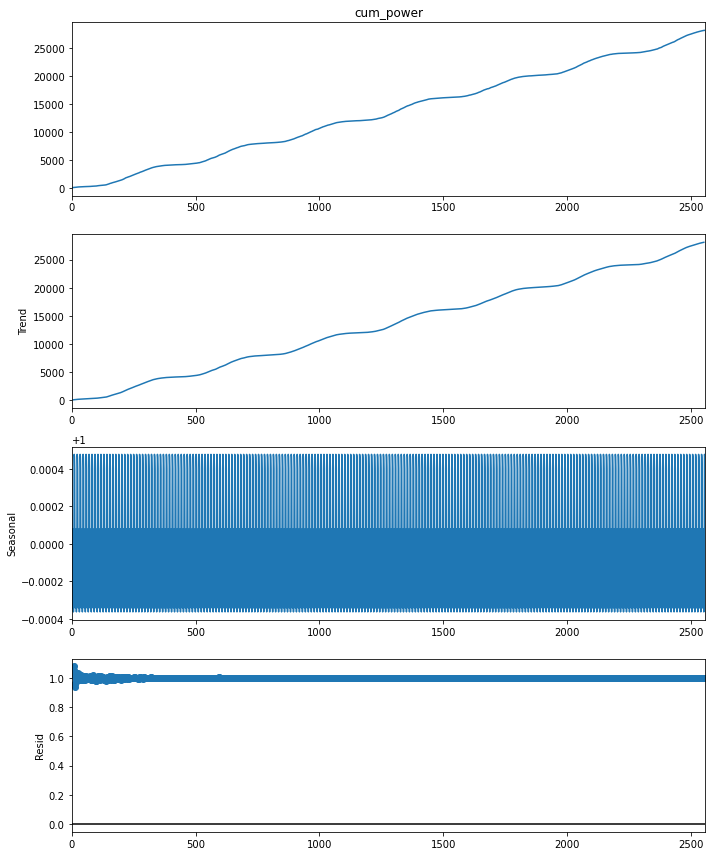

In [13]:
# Multiplicative Model

decompose_mul = sm.tsa.seasonal_decompose(data.cum_power, model = 'multiplicative', period=12)
decompose_mul.plot()

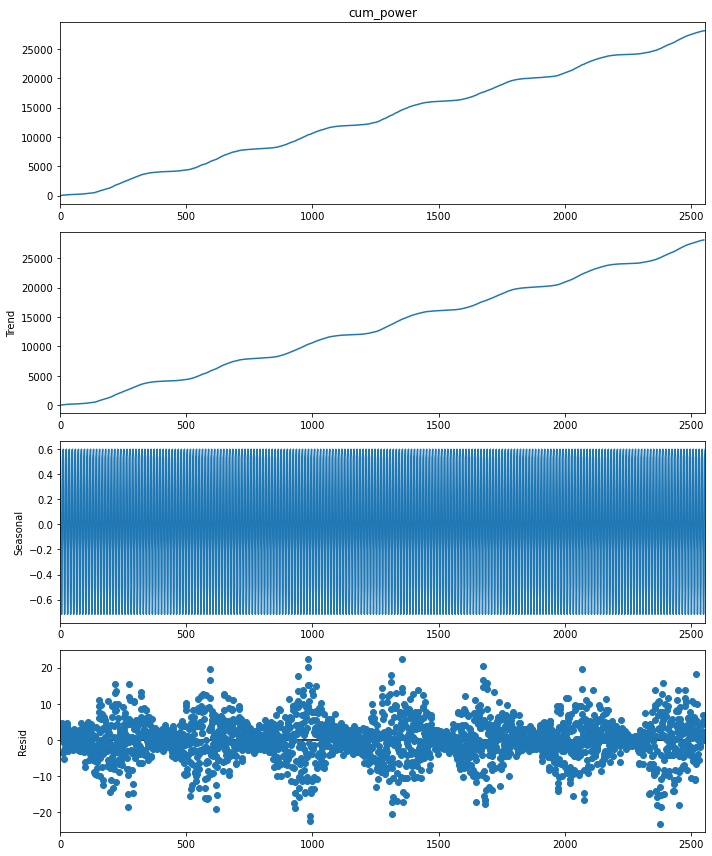

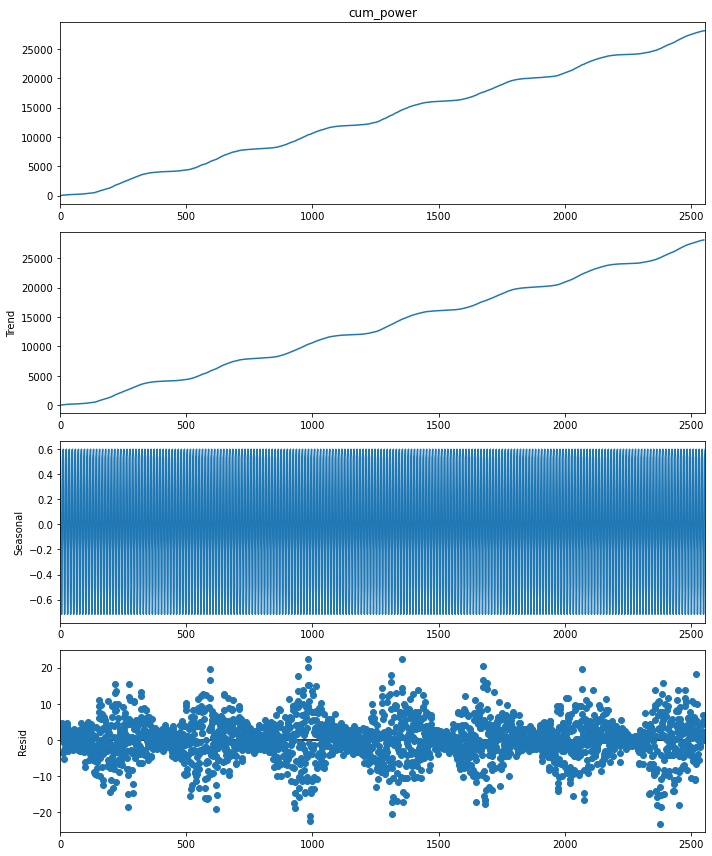

In [14]:
# Additive Model

decompose_add = sm.tsa.seasonal_decompose(data.cum_power, model = 'additive', period=12)
decompose_add.plot()

## ARIMA Model

In [15]:
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
data.shape

(2558, 2)

In [17]:
train = data.head(2046)
test = data.tail(512)

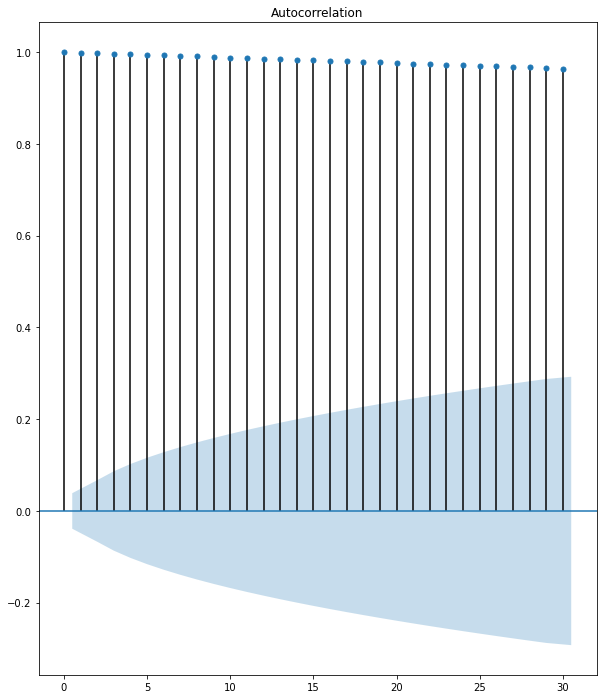

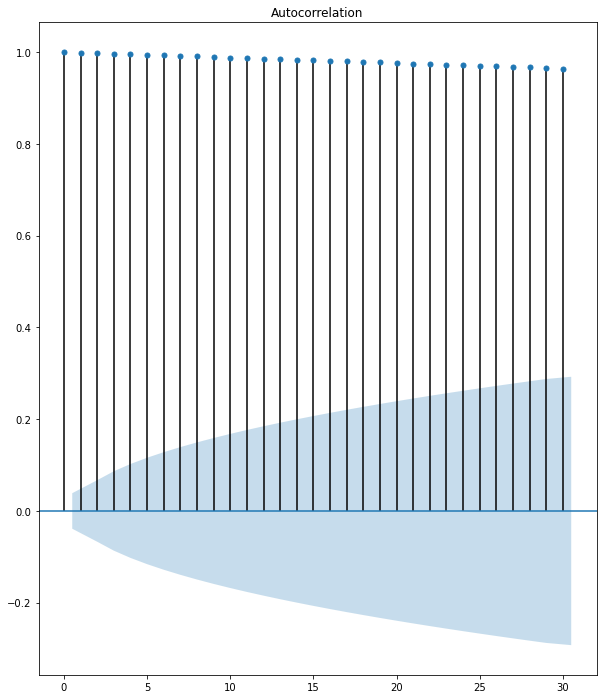

In [19]:
tsa_plots.plot_acf(data.cum_power,lags=30)

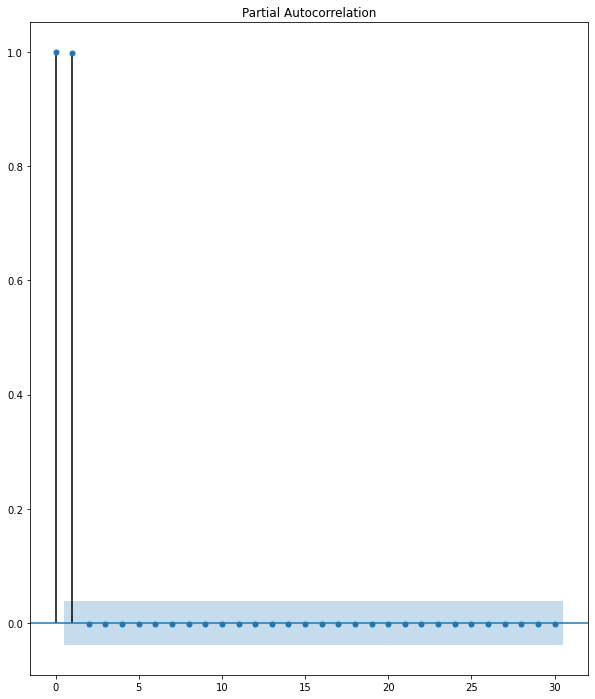

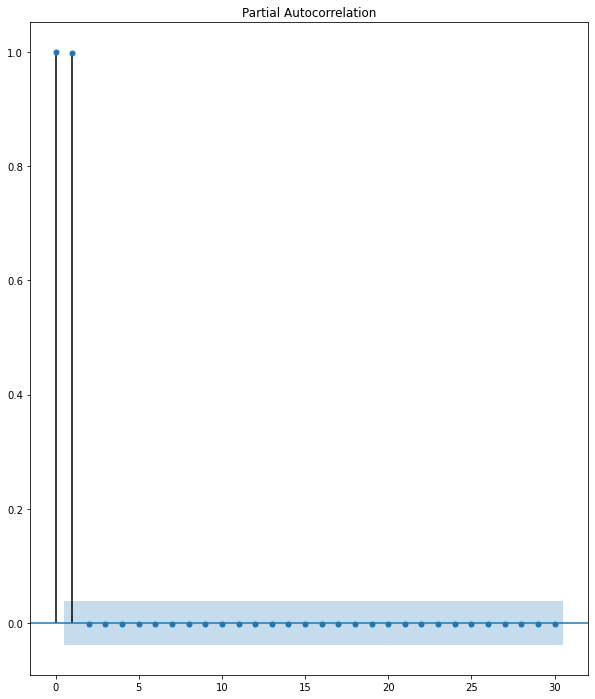

In [20]:
tsa_plots.plot_pacf(data.cum_power,lags=30)

In [21]:
# Auto ARIMA will automatically discover the optimal order for an ARIMA model

import pmdarima as pm

In [22]:
ar_model = pm.auto_arima(data.cum_power, start_p=0,start_q=0,
                        max_p=12,max_q=12,
                        m=1,
                        d=None,
                        seasonal=False,
                        start_P=0,trace=True,
                        error_action='warn',stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18025.637, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15947.568, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16895.797, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20652.126, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15701.892, Time=1.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15535.761, Time=1.74 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15481.458, Time=2.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=15440.824, Time=1.65 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=15417.796, Time=2.19 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=15400.516, Time=2.40 sec
 ARIMA(8,1,0)(0,0,0)[0] intercept   : AIC=15384.142, Time=2.63 sec
 ARIMA(9,1,0)(0,0,0)[0] intercept   : AIC=15373.994, Time=3.38 sec
 ARIMA(10,1,0)(0,0,0)[0] intercept   : AIC=15365.384, Time=3.63 sec
 ARIMA(11,1,0)(0,0,0)[0] intercept   : AIC=15344.211, Time=5.01 sec
 ARIMA(12,1,0)(0,

In [24]:
# Best Parameters ARIMA(4,1,1)(0,0,0)[0]

model = ARIMA(train.cum_power, order=(4,1,1))
res=model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              cum_power   No. Observations:                 2046
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -6104.678
Date:                Wed, 12 Jan 2022   AIC                          12221.357
Time:                        16:31:35   BIC                          12255.096
Sample:                             0   HQIC                         12233.731
                               - 2046                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2248      0.023     54.345      0.000       1.181       1.269
ar.L2         -0.2204      0.028     -7.978      0.000      -0.275      -0.166
ar.L3          0.0284      0.027      1.046      0.2

In [25]:
# Forecast on train data

start_index = len(train)
end_index = start_index + 511
forecast_best = res.predict(start=start_index,end=end_index)
print(forecast_best)

2046    21765.989206
2047    21786.875846
2048    21807.883051
2049    21828.890377
2050    21849.868734
            ...     
2553    28940.290605
2554    28949.200876
2555    28958.096011
2556    28966.976037
2557    28975.840979
Length: 512, dtype: float64


In [27]:
# Evaluate Forecast

rmse_best = sqrt(mean_squared_error(test.cum_power, forecast_best))
print('Test RMSE: %.3f' % rmse_best)

Test RMSE: 1310.816


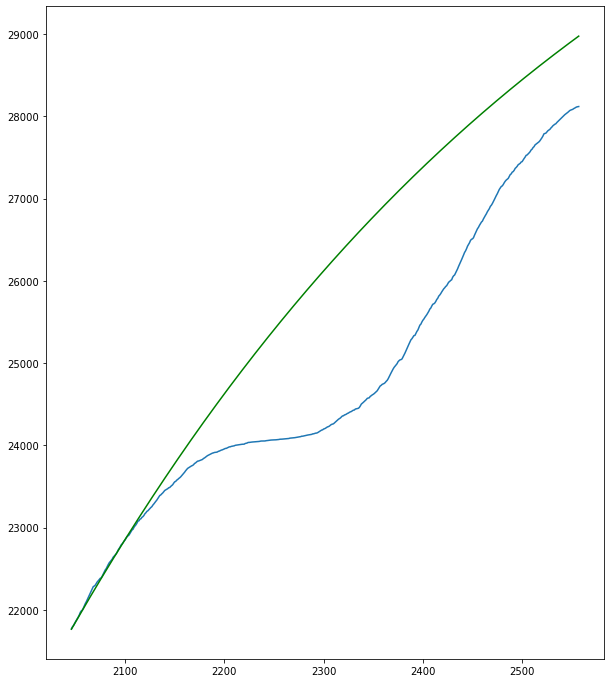

In [28]:
# PLotting forecasted against actual numbers

plt.plot(test.cum_power)
plt.plot(forecast_best, color='green')
plt.show()

## Forecasting using Data Driven Approach

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
# Creating a function which will calculate MAPE

def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

#### Simple Expotential Method

In [40]:
ses_model = SimpleExpSmoothing(train['cum_power']).fit()
pred_ses = ses_model.predict(start=test.index[0], end=test.index[-1])
mape_SEM = MAPE(pred_ses, test.cum_power)
mape_SEM

11.92554881872599

#### HOLT Winter

In [41]:
hw_model = Holt(train['cum_power']).fit()
pred_hw_model = hw_model.predict(start=test.index[0],end=test.index[-1])
mape_HM = MAPE(pred_hw_model,test.cum_power)
mape_HM

9.599401904098984

#### Holt Winter exponential smoothing with additive seasonality and additive trend

In [42]:
hw_model_add_add = ExponentialSmoothing(train['cum_power'], seasonal='add', trend='add',seasonal_periods=4).fit()
pred_hw_model_add_add = hw_model_add_add.predict(start=test.index[0],end=test.index[-1])
mape_HWE_add = MAPE(pred_hw_model_add_add, test.cum_power)
mape_HWE_add

C:\Users\jaic208\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


9.913948257033809

#### Holt Winter Exponential smoothing with multiplicative seasonality and additive trend

In [51]:
hw_model_mul_add = ExponentialSmoothing(train['cum_power'], seasonal='mul',trend='add', seasonal_periods=4).fit()
pred_hw_model_mul_add = hw_model_mul_add.predict(start=test.index[0],end=test.index[-1])
mape_HWE_mul = MAPE(pred_hw_model_mul_add, test.cum_power)
mape_HWE_mul

C:\Users\jaic208\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


1.6457193092372941

In [44]:
data_mape = {"MODEL":pd.Series(["Simple Exponential Method","Holt method","HWE smoothing with add. Sn. & add. trend","HWE smoothing with Mul. Sn. & add. trend"]),"RMSE_Values":pd.Series([mape_SEM,mape_HM,mape_HWE_add,mape_HWE_mul])}
table_mape=pd.DataFrame(data_mape)
table_mape

,MODEL,RMSE_Values
0,Simple Exponential Method,11.925549
1,Holt method,9.599402
2,HWE smoothing with add. Sn. & add. trend,9.913948
3,HWE smoothing with Mul. Sn. & add. trend,1.645719


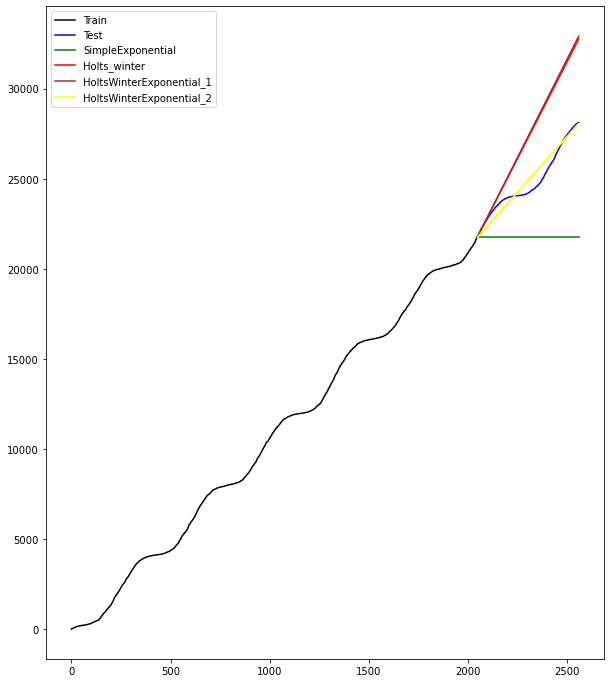

In [48]:
plt.plot(train.index, train["cum_power"], label='Train',color="black")
plt.plot(test.index, test["cum_power"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw_model.index, pred_hw_model, label='Holts_winter',color="red")
plt.plot(pred_hw_model_add_add.index,pred_hw_model_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hw_model_mul_add.index,pred_hw_model_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')

In [49]:
# Final model of Holt Winters Multiplicative Seasonality and Additive Trend on 100% data

In [52]:
final_model = ExponentialSmoothing(data['cum_power'],seasonal='mul',trend='add',seasonal_periods=4).fit()

C:\Users\jaic208\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


In [53]:
data.tail()

,date,cum_power,t,t_squared,log_power
2553,2018-10-22,28101.0,2553,6517809,10.243560
2554,2018-10-23,28109.0,2554,6522916,10.243845
2555,2018-10-24,28115.0,2555,6528025,10.244059
2556,2018-10-25,28117.0,2556,6533136,10.244130
2557,2018-10-26,28120.0,2557,6538249,10.244236


In [54]:
new_data = pd.read_excel('solarpower_predictions.xlsx')
new_data

,date,cum_power
0,2018-10-27,NaN
1,2018-10-28,NaN
2,2018-10-29,NaN
3,2018-10-30,NaN
4,2018-10-31,NaN
...,...,...
94,2019-01-29,NaN
95,2019-01-30,NaN
96,2019-01-31,NaN
97,2019-02-01,NaN


In [56]:
newdata_pred = final_model.predict(start=new_data.index[0],end = new_data.index[-1])
newdata_pred

0    -190.940744
1     182.945147
2      40.253466
3      33.409743
4      -8.487150
         ...    
94    292.470609
95    294.627314
96    296.117122
97    297.459184
98    303.915107
Length: 99, dtype: float64

In [58]:
new_data['cum_power_Predicted'] = pd.Series(newdata_pred)
new_data.drop(columns='cum_power',inplace=True)
new_data

,date,cum_power_Predicted
0,2018-10-27,-190.940744
1,2018-10-28,182.945147
2,2018-10-29,40.253466
3,2018-10-30,33.409743
4,2018-10-31,-8.487150
...,...,...
94,2019-01-29,292.470609
95,2019-01-30,294.627314
96,2019-01-31,296.117122
97,2019-02-01,297.459184


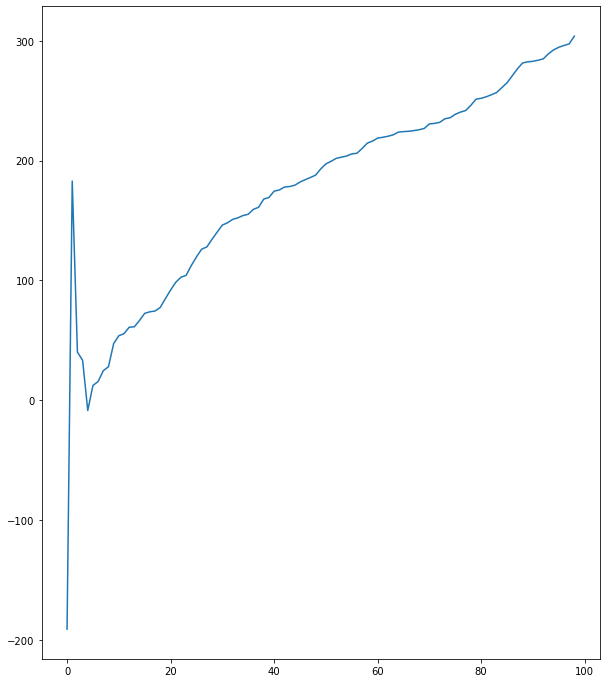

In [59]:
plt.plot(new_data['cum_power_Predicted'])